## The imapact of the batch_size on grid-wise statistics

For grid-wise statistics, we need to use batch-based approach to fit data into the memory. Though the pooled statistics is well-established, we want to verify the results is acceptable.

In [2]:
import numpy as np
import pandas as pd
import os, argparse, logging

# Utility functions
def list_himawari8_files(dir, suffix='.btp', to_remove='.B13.PCCU.btp'):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    xfiles = []
    for root, dirs, files in os.walk(dir): 
        for fn in files:
            if fn.endswith(suffix): 
                 xfiles.append({'timestamp':fn.replace(to_remove,''), 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_himawari8_btp(furi):
    ''' The method reads in a Himawari 8 image in binary format (.btp file). 
        the binary file contains 10,890,000 float point numbers (4-byte) represent 
        the brightness temperature. '''
    data = np.fromfile(furi, np.float32)
    return(data.reshape((3300,3300)))

def read_multiple_himawari8(flist, test_flag=False):
    data = []
    for f in flist:
        if test_flag:
            data.append(read_himawari8_btp(f)[1600:1700,1600:1700])
        else:
            data.append(read_himawari8_btp(f))
    return(np.array(data))

# Statistical summary
# Per-grid analysis
def summarize_by_grid(data):
    ''' Given a 3D numpy array, calculate the mean and variance on the first axis. '''
    mean_image = np.mean(data, axis=0)
    var_image = np.var(data, axis=0)
    return({'mean':mean_image, 'variance':var_image})

def summarize_himawari8_by_grid(flist, batch_size=None):
    ''' Calculate grid-by-grid statistics of a list of Himawari-8 images. '''
    if batch_size is None:  # Read in all data
        data = read_multiple_himawari8(flist)
        summary = summarize_images_by_grid(data)
    else:                   # Read in data by batch
        pooled_mean = None
        pooled_var = None
        nSample = len(flist)
        batch_start = 0
        batch_end = batch_size
        batch_count = 0
        # Loop through all files
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            logging.debug("Batch "+str(batch_count)+', size:'+str(limit-batch_start))
            data = read_multiple_himawari8(flist[batch_start:limit])#, test_flag=True)
            # calculate statistics by increment
            tmp = summarize_by_grid(data)
            if pooled_mean is None:
                pooled_mean = (limit - batch_start)*tmp['mean']
                pooled_var = (limit - batch_start - 1)*tmp['variance']
            else:
                pooled_mean += (limit - batch_start)*tmp['mean']
                pooled_var += (limit - batch_start - 1)*tmp['variance']
            # increment
            batch_start += batch_size   
            batch_end += batch_size
            batch_count += 1
        # Pooling
        pooled_mean = pooled_mean/nSample
        pooled_var = pooled_var/(nSample-batch_count)
        summary={'mean':pooled_mean, 'variance':pooled_var}
    # 
    return(summary)


In [6]:
logging.basicConfig(level=logging.INFO)
b10m = read_himawari8_btp('testb10mean.btp')
b30m = read_himawari8_btp('testb30mean.btp')
b50m = read_himawari8_btp('testb50mean.btp')
b10v = read_himawari8_btp('testb10var.btp')
b30v = read_himawari8_btp('testb30var.btp')
b50v = read_himawari8_btp('testb50var.btp')

In [4]:
print('Mean')
print('b10-b30:')
print(np.percentile((b10m-b30m),[0,25,50,75,100]))
print('b10-b50:')
print(np.percentile((b10m-b50m),[0,25,50,75,100]))
print('b30-b50:')
print(np.percentile((b30m-b50m),[0,25,50,75,100]))

Mean
b10-b30:
[-1.22070312e-04 -1.52587891e-05  0.00000000e+00  0.00000000e+00
  9.15527344e-05]
b10-b50:
[-1.22070312e-04 -1.52587891e-05  0.00000000e+00  3.05175781e-05
  1.22070312e-04]
b30-b50:
[-1.22070312e-04  0.00000000e+00  0.00000000e+00  3.05175781e-05
  1.52587891e-04]


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228CF3FA108>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228CF3FA108>
DEBUG:matplotlib.colorbar:Setting pcolormesh


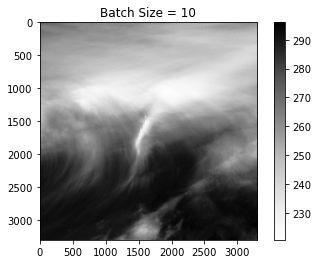

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228DAAA7208>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228DAAA7208>
DEBUG:matplotlib.colorbar:Setting pcolormesh


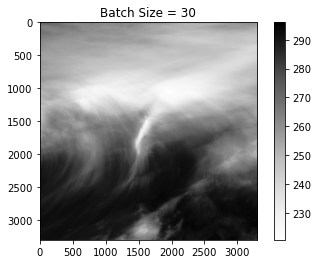

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228DD504108>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228DD504108>
DEBUG:matplotlib.colorbar:Setting pcolormesh


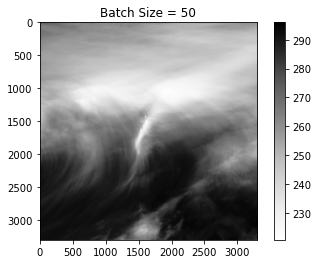

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(b10m, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 10')
plt.colorbar()
plt.show()

plt.imshow(b30m, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 30')
plt.colorbar()
plt.show()

plt.imshow(b50m, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 50')
plt.colorbar()
plt.show()

For mean values in each grid, the pattern is similar and the difference is negligable ($10^{-4}$ ~ $10^{-5}$).

In [8]:
print('Variance')
print('b10-b30:')
print(np.percentile(np.abs(b10v-b30v),[0,25,50,75,100]))
print('b10-b50:')
print(np.percentile(np.abs(b10v-b50v),[0,25,50,75,100]))
print('b30-b50:')
print(np.percentile(np.abs(b30v-b50v),[0,25,50,75,100]))

Variance
b10-b30:
[1.33587718e-02 1.56446810e+01 4.07077560e+01 8.13573837e+01
 5.42070801e+02]
b10-b50:
[5.13681173e-02 2.65801811e+01 6.98671570e+01 1.41442719e+02
 8.45840515e+02]
b30-b50:
[2.86102295e-06 5.29846191e+00 2.45442505e+01 6.18200722e+01
 7.81613403e+02]


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228DFF4EEC8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228DFF4EEC8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


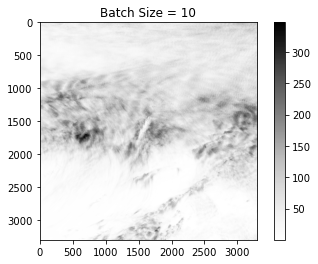

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228E3968F08>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228E3968F08>
DEBUG:matplotlib.colorbar:Setting pcolormesh


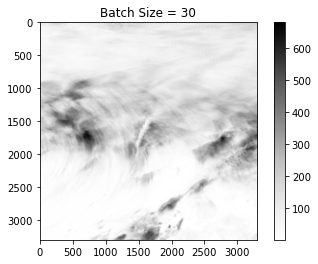

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228E63C4888>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000228E63C4888>
DEBUG:matplotlib.colorbar:Setting pcolormesh


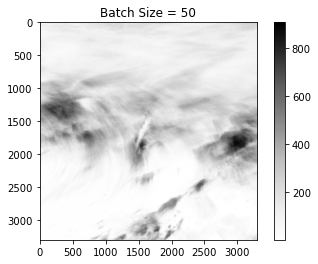

In [9]:
plt.imshow(b10v, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 10')
plt.colorbar()
plt.show()

plt.imshow(b30v, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 30')
plt.colorbar()
plt.show()

plt.imshow(b50v, alpha=0.99, cmap='Greys')
plt.title('Batch Size = 50')
plt.colorbar()
plt.show()